# Metadata

Author:    Qing Liu

Date:      04/30/2023

**Purpose**: In this notebook we create a topic model from our corpus  using SciKit Learn's library.

# Set Up

## Config

In [110]:
data_in = '/Users/poppy/Documents/TeachSim Project/Robertson_Semantic/Data/output'
data_out = '/Users/poppy/Documents/TeachSim Project/Robertson_Semantic/Data/output'
local_lib = '/Users/poppy/Documents/TeachSim Project/Robertson_Semantic/lib'
colors = "YlGnBu"

In [111]:
ngram_range = [1,2]
n_terms = 1000
n_topics = 10
# n_topics = 20
max_iter = 20
n_top_terms = 9

In [112]:
OHCO = ['document_id', 'paragraph_id', 'sentence_id', 'token_id']
PARA = OHCO[:2]

In [113]:
BAG = PARA

## Imports

In [114]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
import plotly_express as px

## Pragmas

In [115]:
import warnings
warnings.filterwarnings('ignore')

# Prepare Data

## Convert `TOKENS` back to `DOCS`

Scikit Learn wants an F1 style corpus. We create onefrom our annotated TOKEN table, keeping only regular nouns.

In [116]:
TOKENS = pd.read_csv(f'{data_in}/CORPUS.csv')

In [117]:
TOKENS.head()

,document_id,paragraph_id,sentence_id,token_id,term_str,POS,speaker,coach_flag,stopword_flag,unimportant_flag
0,02_004_22c_100,1,1,3,tell,VB,Kristyn,1,0,0
1,02_004_22c_100,1,1,8,feel,VB,Kristyn,1,0,0
2,02_004_22c_100,1,2,2,give,VB,Kristyn,1,0,0
3,02_004_22c_100,1,2,5,thoughts,NNS,Kristyn,1,0,0
4,02_004_22c_100,1,3,3,vent,VB,Kristyn,1,0,0


In [118]:
BAG

['document_id', 'paragraph_id']

## Filter for Nouns and Verbs and Adjectives

In [119]:
#drop NAs from POS
TOKENS = TOKENS.dropna(subset=['POS'])

In [120]:
DOCS = TOKENS[TOKENS.POS.str.match(r'^(NN|VB|JJ)S?$')]\
    .groupby(BAG).term_str\
    .apply(lambda x: ' '.join(x))\
    .to_frame()\
    .rename(columns={'term_str':'doc_str'})

In [121]:
DOCS.head()

doc_str
document_id    paragraph_id                                                   
01_004_12c_001 1                   right real quick minute timer see classroom
               2                                               empty classroom
               3             student screen black ask seconds see kids hand...
               4             second question able get elaboration sure kind...
               5             transition fine thing kind sort sum something ...

## Create Vector Space

We use Scikit Learn's CountVectorizer to convert our F1 corpus of paragraphs into a document-term vector space of word counts.

In [122]:
count_engine = CountVectorizer(max_features=n_terms, ngram_range=ngram_range, stop_words='english')
count_model = count_engine.fit_transform(DOCS.doc_str)
TERMS = count_engine.get_feature_names_out()

In [123]:
VOCAB = pd.DataFrame(index=TERMS)
VOCAB.index.name = 'term_str'

In [124]:
DTM = pd.DataFrame(count_model.toarray(), index=DOCS.index, columns=TERMS)

In [125]:
#DTM

In [126]:
VOCAB['doc_count'] = DTM.astype('bool').astype('int').sum()
DOCS['term_count'] = DTM.sum(1)

In [127]:
# VOCAB

In [128]:
DOCS.term_count.describe()

count    3694.00000
mean       12.98105
std        18.71628
min         0.00000
25%         2.00000
50%         6.00000
75%        16.00000
max       163.00000
Name: term_count, dtype: float64

# Generate Model

We run Scikit Learn's [LatentDirichletAllocation algorithm](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html#sklearn.decomposition.LatentDirichletAllocation) and extract the THETA and PHI tables.

In [129]:
lda_engine = LDA(n_components=n_topics, max_iter=max_iter, learning_offset=50., random_state=0)

## Topic Names

In [130]:
TNAMES = [f"T{str(x).zfill(len(str(n_topics)))}" for x in range(n_topics)]

In [131]:
#TNAMES

## THETA

In [132]:
lda_model = lda_engine.fit_transform(count_model)

In [133]:
THETA = pd.DataFrame(lda_model, index=DOCS.index)
THETA.columns.name = 'topic_id'
THETA.columns = TNAMES

In [134]:
THETA.sample(20).style.background_gradient(cmap=colors, axis=None)

,,T00,T01,T02,T03,T04,T05,T06,T07,T08,T09
document_id,paragraph_id,,,,,,,,,,
02_004_12c_0086,1,0.549951,0.050004,0.050005,0.050003,0.050010,0.050007,0.050003,0.050004,0.050009,0.050004
01_004_12c_048,19,0.025000,0.025000,0.273234,0.025007,0.025000,0.025000,0.526757,0.025001,0.025001,0.025000
03_2022_004_12c_052,25,0.020000,0.020000,0.020000,0.020000,0.020001,0.020015,0.020000,0.020000,0.020001,0.819983
03_2022_004_22c_001,15,0.006667,0.006667,0.006667,0.163099,0.229886,0.006667,0.560349,0.006667,0.006667,0.006667
02_004_12c_003,4,0.005882,0.005883,0.171427,0.005883,0.781506,0.005884,0.005883,0.005885,0.005884,0.005883
03_004_22c_032,9,0.549951,0.050004,0.050005,0.050003,0.050010,0.050007,0.050003,0.050004,0.050009,0.050004
03_004_12c_011,5,0.008333,0.008333,0.008334,0.008334,0.008334,0.008333,0.008335,0.008334,0.924994,0.008335
01_004_22c_067,19,0.025000,0.025007,0.025001,0.025002,0.025000,0.025011,0.774971,0.025000,0.025003,0.025005
01_004_12c_055,5,0.001961,0.001961,0.001961,0.001961,0.773462,0.001961,0.001961,0.210849,0.001961,0.001962


## PHI

In [135]:
PHI = pd.DataFrame(lda_engine.components_, columns=TERMS, index=TNAMES)
PHI.index.name = 'topic_id'
PHI.columns.name  = 'term_str'

In [136]:
PHI.T.sample(20).style.background_gradient(cmap=colors, axis=None)

topic_id,T00,T01,T02,T03,T04,T05,T06,T07,T08,T09
term_str,,,,,,,,,,
chat follow,0.100002,0.100000,0.100000,0.100000,0.100004,0.100002,0.100000,10.099982,0.100004,0.100006
text kind,0.100011,0.100006,0.100035,0.100001,2.427010,0.100002,0.100000,0.100009,11.772923,0.100003
stop,0.100001,77.699177,0.100008,354.276110,0.100004,0.100010,367.324686,0.100001,0.100001,0.100004
short specific,0.100000,0.100008,0.100001,16.099970,0.100001,0.100007,0.100009,0.100000,0.100000,0.100004
high,6.029750,2.204624,0.100056,0.100025,0.100011,0.100009,0.100006,4.065492,0.100003,0.100023
spy,0.100018,0.100001,29.815576,0.100001,3.782486,0.100008,0.100001,3.616052,15.185850,0.100009
activity,0.100000,0.100020,0.100014,11.099927,0.100018,0.100002,0.100007,0.100000,0.100007,0.100004
scaffold,0.100031,0.100001,0.100014,0.100000,18.116928,3.439153,0.100001,18.448657,7.395198,0.100017
simple,0.100000,0.100000,0.100034,0.100010,0.100035,1.196191,11.547985,2.555732,0.100002,0.100011


# Inspect Results

## Create `TOPICS` and get Top Terms per Topic

In [137]:
TOPICS = PHI.stack().to_frame('topic_weight').groupby('topic_id')\
    .apply(lambda x: x.sort_values('topic_weight', ascending=False)\
        .head(n_top_terms).reset_index().drop('topic_id', axis=1)['term_str'])

In [138]:
TOPICS

term_str,0,1,2,3,4,5,6,7,8
topic_id,,,,,,,,,
T00,detector,lie,lie detector,results,detector results,feel,think,good,likely
T01,classroom,norms,class,let,classroom norms,time,norm,talk,stop
T02,kind,little,like,bit,little bit,know,thing,um,lot
T03,specific,behavior,stop,redirection,student,students,way,behaviors,time
T04,students,sure,make,questions,make sure,text,calm,kind,think
T05,simulation,great,right,try,job,round,questions,ready,time
T06,stop,say,time,attention,book,student,try,classroom,let
T07,evidence,text,answer,text evidence,students,textual,textual evidence,tell,job
T08,student,paragraph,text,say,intern,look,student intern,right,read


In [139]:
TOPICS['label'] = TOPICS.apply(lambda x: x.name + ' ' + ', '.join(x[:n_top_terms]), 1)

In [140]:
print(TOPICS.label.values)

['T00 detector, lie, lie detector, results, detector results, feel, think, good, likely'
 'T01 classroom, norms, class, let, classroom norms, time, norm, talk, stop'
 'T02 kind, little, like, bit, little bit, know, thing, um, lot'
 'T03 specific, behavior, stop, redirection, student, students, way, behaviors, time'
 'T04 students, sure, make, questions, make sure, text, calm, kind, think'
 'T05 simulation, great, right, try, job, round, questions, ready, time'
 'T06 stop, say, time, attention, book, student, try, classroom, let'
 'T07 evidence, text, answer, text evidence, students, textual, textual evidence, tell, job'
 'T08 student, paragraph, text, say, intern, look, student intern, right, read'
 'T09 question, nervous, heart, ask, practice, student, let, sorry, paragraph']


## Sort Topics by Doc Weight

In [141]:
PHI

term_str,able,able tell,acceptable,action,activity,actual,add,additional,address,agree,...,worry,write,wrong,wrong answer,wrong answers,wrong text,year,yep,yes,zero
topic_id,,,,,,,,,,,,,,,,,,,,,
T00,2.770667,0.100006,0.100000,0.100000,0.100000,0.100016,0.100007,0.100001,0.100013,0.100010,...,0.100011,0.100000,0.100014,0.100019,0.100000,0.100016,0.100000,2.099988,0.100005,0.100000
T01,0.100028,0.100059,0.100021,0.100032,0.100020,16.530806,0.100039,0.100007,3.079406,0.100003,...,5.438643,5.750281,0.100007,0.100001,0.100001,0.100001,1.361243,0.100001,0.100004,0.100007
T02,12.143316,0.100001,0.100017,0.100016,0.100014,0.100040,6.827504,1.559339,0.100029,0.100023,...,0.100042,0.100006,0.100020,0.100003,0.100004,0.100004,15.838661,1.876496,18.254311,0.100003
T03,41.583184,1.199789,15.099913,1.575694,11.099927,1.449557,4.895077,0.100030,45.355774,0.100003,...,0.100018,0.100032,0.100011,0.100000,0.100000,0.100000,0.100007,0.100014,0.100006,9.099977
T04,41.386809,0.100003,0.100003,0.100004,0.100018,0.100021,0.100028,1.149402,0.100065,15.599876,...,0.100019,0.100007,17.282079,0.100023,7.824350,0.100026,0.100005,0.100038,0.100012,0.100000
T05,0.100013,0.100017,0.100002,0.100001,0.100002,0.100005,0.100030,4.469535,0.100010,0.100006,...,0.100034,8.449640,0.100012,0.100002,0.100001,0.100009,0.100071,0.100041,0.100003,0.100000
T06,10.424932,0.100004,0.100032,13.624247,0.100007,0.100011,11.429448,0.100001,7.126472,0.100008,...,3.772740,0.100016,0.100007,0.100000,0.100000,0.100000,0.100010,21.501260,0.100012,0.100000
T07,15.316990,0.100009,0.100000,0.100001,0.100000,6.774782,11.247823,24.221679,0.100023,2.600027,...,2.011793,0.100001,142.115853,48.707540,2.375637,4.192962,0.100001,0.100026,0.100019,0.100000
T08,51.074040,12.000104,0.100000,0.100004,0.100007,0.100042,0.100024,0.100004,6.838186,0.100028,...,1.176695,0.100016,38.901985,1.492388,0.100007,5.006977,0.100001,3.922089,2.945622,0.100000


In [142]:
TOPICS['doc_weight_sum'] = THETA.sum()
TOPICS['term_freq'] = PHI.sum(1) / PHI.sum(1).sum()

In [143]:
TOPICS

term_str,0,1,2,3,4,5,6,7,8,label,doc_weight_sum,term_freq
topic_id,,,,,,,,,,,,
T00,detector,lie,lie detector,results,detector results,feel,think,good,likely,"T00 detector, lie, lie detector, results, dete...",273.710248,0.045935
T01,classroom,norms,class,let,classroom norms,time,norm,talk,stop,"T01 classroom, norms, class, let, classroom no...",382.954835,0.081370
T02,kind,little,like,bit,little bit,know,thing,um,lot,"T02 kind, little, like, bit, little bit, know,...",462.697726,0.106244
T03,specific,behavior,stop,redirection,student,students,way,behaviors,time,"T03 specific, behavior, stop, redirection, stu...",453.470317,0.181161
T04,students,sure,make,questions,make sure,text,calm,kind,think,"T04 students, sure, make, questions, make sure...",295.634128,0.093861
T05,simulation,great,right,try,job,round,questions,ready,time,"T05 simulation, great, right, try, job, round,...",388.448932,0.059918
T06,stop,say,time,attention,book,student,try,classroom,let,"T06 stop, say, time, attention, book, student,...",357.006222,0.074559
T07,evidence,text,answer,text evidence,students,textual,textual evidence,tell,job,"T07 evidence, text, answer, text evidence, stu...",366.675085,0.166501
T08,student,paragraph,text,say,intern,look,student intern,right,read,"T08 student, paragraph, text, say, intern, loo...",390.025732,0.139003


### Interpretation:
The document weight sum provides an overall distribution of topics within the entire corpus. Aftering sorting topics by their document weight sum, according to the table, we observe that T02 topic, which has the largest document weight and indicates its dominancy in the corpus, includes words such as "kind, little, like, bit, little bit, know, thing, um, lot". Within the context of conversations between coaches and preservice teachers, this topic appears to center around expressions frequently employed by preservice teachers to temper their statements, conveying a sense of uncertainty and hesitation.

Meanwhile, the T03 predominantly concerns student off-task behaviors and preservice teachers' redirection efforts. In contrast, the T04 appears to be more closely related to conversations within the realm of text-based discussions.


Figure 3. Document weight sum by each topic


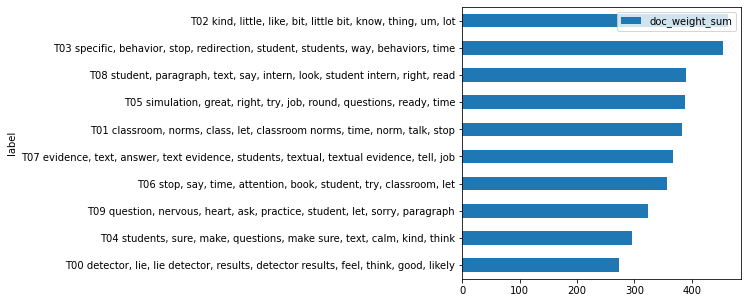

In [144]:
print("Figure 3. Document weight sum by each topic")
TOPICS.sort_values('doc_weight_sum', ascending=True).plot.barh(y='doc_weight_sum', x='label', figsize=(5, n_topics/2));

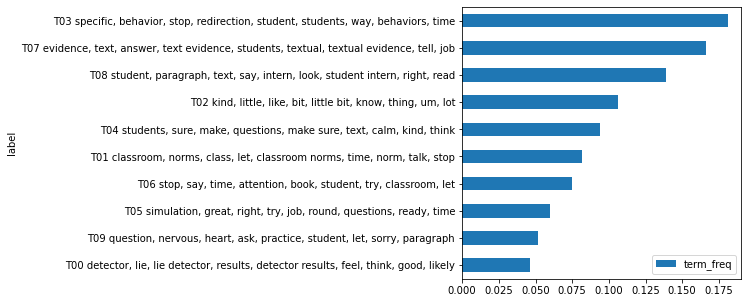

In [145]:
TOPICS.sort_values('term_freq', ascending=True).plot.barh(y='term_freq', x='label', figsize=(5,n_topics/2));

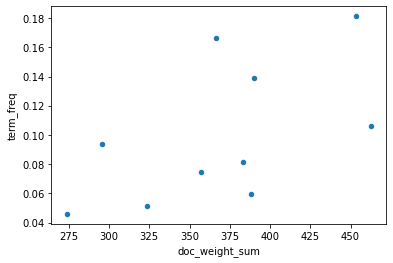

In [146]:
TOPICS.plot.scatter('doc_weight_sum', 'term_freq');

# Explore Topics by Site and Scenario

Use the LIB table to get information

In [147]:
LIB = pd.read_csv(f'/Users/poppy/Documents/TeachSim Project/Robertson_Semantic/Data/output/LIB.csv').set_index('document_id')

Add mean topic weight for each topic by author.

In [148]:
sites = sorted(LIB.site_id.value_counts().index.to_list())

In [149]:
scenarios = sorted(LIB.scenario_id.value_counts().index.to_list())

In [150]:
# THETA.join(LIB, on='book_id')\
#     .groupby('author_key')[TNAMES].mean()\
#     .T

In [151]:
TOPICS[sites] = THETA.join(LIB, on='document_id').groupby('site_id')[TNAMES].mean().T

In [152]:
TOPICS[scenarios] = THETA.join(LIB, on='document_id').groupby('scenario_id')[TNAMES].mean().T

In [153]:
TOPICS

term_str,0,1,2,3,4,5,6,7,8,label,doc_weight_sum,term_freq,RGV,SMU,UVA,CN,QF
topic_id,,,,,,,,,,,,,,,,,
T00,detector,lie,lie detector,results,detector results,feel,think,good,likely,"T00 detector, lie, lie detector, results, dete...",273.710248,0.045935,0.071752,0.063316,0.089357,0.045820,0.103978
T01,classroom,norms,class,let,classroom norms,time,norm,talk,stop,"T01 classroom, norms, class, let, classroom no...",382.954835,0.081370,0.095437,0.119613,0.096982,0.161372,0.042690
T02,kind,little,like,bit,little bit,know,thing,um,lot,"T02 kind, little, like, bit, little bit, know,...",462.697726,0.106244,0.105413,0.154922,0.118960,0.135887,0.114022
T03,specific,behavior,stop,redirection,student,students,way,behaviors,time,"T03 specific, behavior, stop, redirection, stu...",453.470317,0.181161,0.102738,0.144769,0.125280,0.209762,0.030814
T04,students,sure,make,questions,make sure,text,calm,kind,think,"T04 students, sure, make, questions, make sure...",295.634128,0.093861,0.092210,0.068314,0.076623,0.055867,0.105567
T05,simulation,great,right,try,job,round,questions,ready,time,"T05 simulation, great, right, try, job, round,...",388.448932,0.059918,0.104231,0.106084,0.105374,0.113566,0.096270
T06,stop,say,time,attention,book,student,try,classroom,let,"T06 stop, say, time, attention, book, student,...",357.006222,0.074559,0.119412,0.070967,0.094503,0.151942,0.038207
T07,evidence,text,answer,text evidence,students,textual,textual evidence,tell,job,"T07 evidence, text, answer, text evidence, stu...",366.675085,0.166501,0.098586,0.083255,0.118117,0.034087,0.168139
T08,student,paragraph,text,say,intern,look,student intern,right,read,"T08 student, paragraph, text, say, intern, loo...",390.025732,0.139003,0.123649,0.097295,0.090342,0.036566,0.178521


View by topic order.

### Interpretation:
Interestingly, the T02 topic (conveying uncertainty and hesitation) and T03 topic (re-directing off-task behaviors) seems to be more prevalent in SMU site, compared to RGV and UVA.

Overall, T08 and T06 topics are more prevalent in RGV site, where T08 seems to suggest that teachers may use various techniques, such as asking students to stop their off-task behaviors, redirecting their attention, and encouraging them to try different activities or focus on their books. Additionally, the words "classroom" and "student" emphasize that these conversations are centered on managing the classroom environment and addressing individual student behaviors.

T07 seems to be the most prevalent in UVA site, which suggests that teachers are emphasizing the importance of finding evidence from texts to support students' answers and arguments. Additionally, words such as "tell" and "job" imply that teachers may provide feedback or guidance to students, helping them improve their skills in extracting and utilizing textual evidence effectively. Overall, this topic reflects the instructional focus on promoting students' comprehension and critical thinking abilities by engaging them with text-based tasks and providing high-quality feedback.

In [157]:
print('Figure 4. Document weight on topics across sites')
TOPICS[sites + ['label']].style.background_gradient(cmap=colors, axis=None)

Figure 4. Document weight on topics across sites


term_str,RGV,SMU,UVA,label
topic_id,,,,
T00,0.071752,0.063316,0.089357,"T00 detector, lie, lie detector, results, detector results, feel, think, good, likely"
T01,0.095437,0.119613,0.096982,"T01 classroom, norms, class, let, classroom norms, time, norm, talk, stop"
T02,0.105413,0.154922,0.118960,"T02 kind, little, like, bit, little bit, know, thing, um, lot"
T03,0.102738,0.144769,0.125280,"T03 specific, behavior, stop, redirection, student, students, way, behaviors, time"
T04,0.092210,0.068314,0.076623,"T04 students, sure, make, questions, make sure, text, calm, kind, think"
T05,0.104231,0.106084,0.105374,"T05 simulation, great, right, try, job, round, questions, ready, time"
T06,0.119412,0.070967,0.094503,"T06 stop, say, time, attention, book, student, try, classroom, let"
T07,0.098586,0.083255,0.118117,"T07 evidence, text, answer, text evidence, students, textual, textual evidence, tell, job"
T08,0.123649,0.097295,0.090342,"T08 student, paragraph, text, say, intern, look, student intern, right, read"


### Interpretation:
In the context of teacher coaching intervention, upon examining the topic weights disaggregated by classroom norms and quality of feedback scenarios, it becomes apparent that topics T01, T03, and T06 are associated with conversations centered around redirecting students' off-task behaviors. Meanwhile, topics T07, T08, and T12 are more closely related to providing feedback or guidance to students during the teaching process.


In [158]:
print('Figure 5. Document weight on topics across scenarios')
TOPICS[scenarios + ['label']].style.background_gradient(cmap=colors, axis=None)

Figure 5. Document weight on topics across scenarios


term_str,CN,QF,label
topic_id,,,
T00,0.045820,0.103978,"T00 detector, lie, lie detector, results, detector results, feel, think, good, likely"
T01,0.161372,0.042690,"T01 classroom, norms, class, let, classroom norms, time, norm, talk, stop"
T02,0.135887,0.114022,"T02 kind, little, like, bit, little bit, know, thing, um, lot"
T03,0.209762,0.030814,"T03 specific, behavior, stop, redirection, student, students, way, behaviors, time"
T04,0.055867,0.105567,"T04 students, sure, make, questions, make sure, text, calm, kind, think"
T05,0.113566,0.096270,"T05 simulation, great, right, try, job, round, questions, ready, time"
T06,0.151942,0.038207,"T06 stop, say, time, attention, book, student, try, classroom, let"
T07,0.034087,0.168139,"T07 evidence, text, answer, text evidence, students, textual, textual evidence, tell, job"
T08,0.036566,0.178521,"T08 student, paragraph, text, say, intern, look, student intern, right, read"


## Assigned Scenario to each topic

In [159]:
TOPICS['scenario'] = TOPICS[scenarios].idxmax(1)

In [160]:
TOPICS.iloc[:,n_top_terms:].sort_values(['scenario','doc_weight_sum'], ascending=[True,False]).style.background_gradient(cmap=colors)

term_str,label,doc_weight_sum,term_freq,RGV,SMU,UVA,CN,QF,scenario
topic_id,,,,,,,,,
T02,"T02 kind, little, like, bit, little bit, know, thing, um, lot",462.697726,0.106244,0.105413,0.154922,0.118960,0.135887,0.114022,CN
T03,"T03 specific, behavior, stop, redirection, student, students, way, behaviors, time",453.470317,0.181161,0.102738,0.144769,0.125280,0.209762,0.030814,CN
T05,"T05 simulation, great, right, try, job, round, questions, ready, time",388.448932,0.059918,0.104231,0.106084,0.105374,0.113566,0.096270,CN
T01,"T01 classroom, norms, class, let, classroom norms, time, norm, talk, stop",382.954835,0.081370,0.095437,0.119613,0.096982,0.161372,0.042690,CN
T06,"T06 stop, say, time, attention, book, student, try, classroom, let",357.006222,0.074559,0.119412,0.070967,0.094503,0.151942,0.038207,CN
T08,"T08 student, paragraph, text, say, intern, look, student intern, right, read",390.025732,0.139003,0.123649,0.097295,0.090342,0.036566,0.178521,QF
T07,"T07 evidence, text, answer, text evidence, students, textual, textual evidence, tell, job",366.675085,0.166501,0.098586,0.083255,0.118117,0.034087,0.168139,QF
T09,"T09 question, nervous, heart, ask, practice, student, let, sorry, paragraph",323.376777,0.051449,0.086571,0.091465,0.084461,0.055132,0.121791,QF
T04,"T04 students, sure, make, questions, make sure, text, calm, kind, think",295.634128,0.093861,0.092210,0.068314,0.076623,0.055867,0.105567,QF


## Topics in Scenario Space

See how topics are associated with scenario dimensions.

In [161]:
px.scatter(TOPICS.reset_index(), 'CN', 'QF', 
           hover_name='label', text='topic_id', 
           size=(TOPICS.CN * TOPICS.QF),
           color='scenario',
           width=800, height=350)

# Exploration - Topic Similarity

In [162]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

In [163]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

## Cluster topics

In [164]:
labels  = [f"{a.upper()} {b}" for a, b in zip(TOPICS.scenario, TOPICS.label)]

In [165]:
labels

['QF T00 detector, lie, lie detector, results, detector results, feel, think, good, likely',
 'CN T01 classroom, norms, class, let, classroom norms, time, norm, talk, stop',
 'CN T02 kind, little, like, bit, little bit, know, thing, um, lot',
 'CN T03 specific, behavior, stop, redirection, student, students, way, behaviors, time',
 'QF T04 students, sure, make, questions, make sure, text, calm, kind, think',
 'CN T05 simulation, great, right, try, job, round, questions, ready, time',
 'CN T06 stop, say, time, attention, book, student, try, classroom, let',
 'QF T07 evidence, text, answer, text evidence, students, textual, textual evidence, tell, job',
 'QF T08 student, paragraph, text, say, intern, look, student intern, right, read',
 'QF T09 question, nervous, heart, ask, practice, student, let, sorry, paragraph']

## BY PHI

### Interpretation
When clustering topics by document weight, it shows that T03 and T06 topics are very close, we might interprete the topic cluster relate to classroom management and redirecting off-task behaviors. For instance, T03 emphasizes the importance of specificity in redirection, acknowledging and stopping problematic behaviors, and managing students' actions, and T06 highlights the role of teacher communication ("say"), time management, and maintaining students' attention. The term "book" may refer to teaching materials or resources, suggesting that the discussion might involve lesson planning and organization.

Figure 6. Topic similarity


<Figure size 432x288 with 0 Axes>

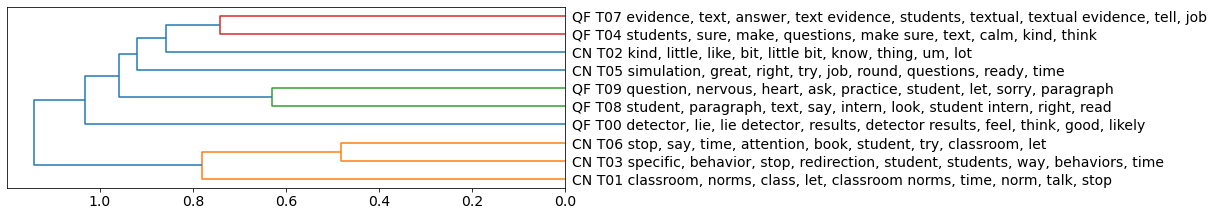

In [168]:
print('Figure 6. Topic similarity')
HAC(PHI, labels=labels).plot();

## By THETA

<Figure size 432x288 with 0 Axes>

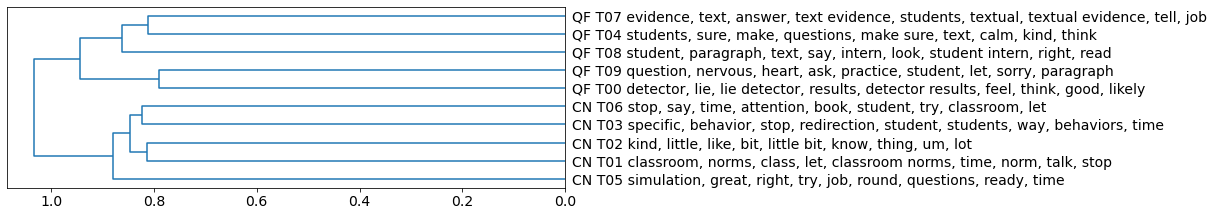

In [171]:
HAC(THETA.T, labels=labels).plot();

# Save Model

In [172]:
DOCS.to_csv(f'{data_out}/LDA_DOCS-para.csv')
TOPICS.to_csv(f'{data_out}/LDA_TOPICS-{n_topics}.csv')
THETA.to_csv(f'{data_out}/LDA_THETA-{n_topics}.csv')
PHI.to_csv(f'{data_out}/LDA_PHI-{n_topics}.csv')

In [115]:
import pickle

In [119]:
pickle.dump(lda_model, open(f'{data_out}/{data_prefix}-lda_model.pickle', 'wb'))
pickle.dump(lda_engine, open(f'{data_out}/{data_prefix}-lda_engine.pickle', 'wb'))
pickle.dump(count_engine, open(f'{data_out}/{data_prefix}-count_engine.pickle', 'wb'))
pickle.dump(count_model, open(f'{data_out}/{data_prefix}-count_model.pickle', 'wb'))